In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [3]:
pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pickle
from catboost import CatBoostClassifier
import pandas as pd
from sqlalchemy import create_engine

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_models():
    from_file = CatBoostClassifier()
    # LOAD MODEL HERE PLS :)
    loaded_model = from_file.load_model(get_model_path("catboost_model"))
    return loaded_model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [5]:
feed_data_limit = 500000
user_data_limit = 163205#114903 163205
post_text_limit = 7023#6924 7023

In [6]:
%%time
from sklearn.decomposition import PCA 
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).drop_duplicates().index.tolist()]

CPU times: user 977 ms, sys: 131 ms, total: 1.11 s
Wall time: 8.57 s


In [7]:
from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data[dummies.columns.to_list()] = dummies


binary_encoder = BinaryEncoder(cols=['age', 'city'])
new_data = binary_encoder.fit_transform(user_data[['age', 'city']])
user_data = pd.concat([user_data, new_data], axis = 1)

user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)
user_data

,user_id,gender_0,gender_1,os_Android,os_iOS,exp_group_0,exp_group_1,exp_group_2,exp_group_3,exp_group_4,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,200,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,201,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,202,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,203,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,204,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163197,168545,0,1,0,1,0,0,0,0,1,...,0,0,1,0,1,1,1,1,1,1
163198,168546,0,1,1,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,0,0
163200,168548,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
163202,168550,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0


In [8]:
%%time
post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()

CPU times: user 62.6 ms, sys: 11.3 ms, total: 73.9 ms
Wall time: 5.15 s


In [9]:
from category_encoders import BinaryEncoder

one_hot_columns = ['topic'] 
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object)) 
post_text[dummies.columns.to_list()] = dummies

In [10]:
from transformers import BertTokenizer
tokenizer, model = get_model('bert')
max_length = 20
embeddings = torch.empty(max_length, 1)
for index,row in post_text.iterrows():
    encoding = tokenizer.encode_plus(row['text'], add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', truncation=True, max_length=max_length,padding='max_length')
    embeddings = torch.cat((embeddings, encoding['input_ids'][0].unsqueeze(1)), 1)

embedding = pd.DataFrame(StandardScaler().fit_transform(embeddings)).T.iloc[1:]
embedding.index = post_text.index
post_text = pd.concat([embedding, post_text], axis=1).drop('text', axis=1)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
post_text

,0,1,2,3,4,5,6,7,8,9,...,19,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,-1.035857,-0.334360,0.480221,0.687481,-0.495645,3.019994,-0.662121,-0.334360,1.100519,0.517669,...,-1.035486,1,business,1,0,0,0,0,0,0
1,-0.819855,1.505225,-0.665458,-0.667131,-0.146137,-0.607198,0.706620,2.554972,1.131934,1.224420,...,-0.819703,2,business,1,0,0,0,0,0,0
2,-0.679099,-0.282190,-0.668002,0.184830,-0.380112,-0.050051,-0.465761,0.106362,-0.671918,2.272127,...,-0.678969,3,business,1,0,0,0,0,0,0
3,-0.542150,-0.205044,-0.243629,0.705870,0.505680,-0.332211,-0.155878,-0.530740,4.147053,-0.331588,...,-0.541943,4,business,1,0,0,0,0,0,0
4,-0.734271,2.751306,2.383996,-0.489397,-0.294551,-0.265441,-0.585503,-0.508267,-0.307862,1.380363,...,-0.734124,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,-0.653672,1.805769,-0.650028,-0.643422,-0.413377,-0.417932,0.497696,-0.033459,-0.637956,3.257108,...,-0.653444,7315,movie,0,0,0,1,0,0,0
7019,-0.795779,-0.780417,-0.263587,-0.440415,0.031013,-0.788269,0.173363,3.299607,-0.396038,-0.453387,...,-0.795438,7316,movie,0,0,0,1,0,0,0
7020,-1.357077,-1.302562,-0.063238,-0.020837,1.014961,-0.095948,0.062754,-0.137137,1.122781,-0.139560,...,-1.355866,7317,movie,0,0,0,1,0,0,0
7021,-0.499439,-0.340433,-0.249889,-0.492340,-0.280964,-0.341222,-0.335228,-0.314564,-0.340591,-0.341380,...,-0.499281,7318,movie,0,0,0,1,0,0,0


#test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies

from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna().drop('topic', axis=1)

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

In [12]:
post_text

,0,1,2,3,4,5,6,7,8,9,...,19,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,-1.035857,-0.334360,0.480221,0.687481,-0.495645,3.019994,-0.662121,-0.334360,1.100519,0.517669,...,-1.035486,1,business,1,0,0,0,0,0,0
1,-0.819855,1.505225,-0.665458,-0.667131,-0.146137,-0.607198,0.706620,2.554972,1.131934,1.224420,...,-0.819703,2,business,1,0,0,0,0,0,0
2,-0.679099,-0.282190,-0.668002,0.184830,-0.380112,-0.050051,-0.465761,0.106362,-0.671918,2.272127,...,-0.678969,3,business,1,0,0,0,0,0,0
3,-0.542150,-0.205044,-0.243629,0.705870,0.505680,-0.332211,-0.155878,-0.530740,4.147053,-0.331588,...,-0.541943,4,business,1,0,0,0,0,0,0
4,-0.734271,2.751306,2.383996,-0.489397,-0.294551,-0.265441,-0.585503,-0.508267,-0.307862,1.380363,...,-0.734124,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,-0.653672,1.805769,-0.650028,-0.643422,-0.413377,-0.417932,0.497696,-0.033459,-0.637956,3.257108,...,-0.653444,7315,movie,0,0,0,1,0,0,0
7019,-0.795779,-0.780417,-0.263587,-0.440415,0.031013,-0.788269,0.173363,3.299607,-0.396038,-0.453387,...,-0.795438,7316,movie,0,0,0,1,0,0,0
7020,-1.357077,-1.302562,-0.063238,-0.020837,1.014961,-0.095948,0.062754,-0.137137,1.122781,-0.139560,...,-1.355866,7317,movie,0,0,0,1,0,0,0
7021,-0.499439,-0.340433,-0.249889,-0.492340,-0.280964,-0.341222,-0.335228,-0.314564,-0.340591,-0.341380,...,-0.499281,7318,movie,0,0,0,1,0,0,0


In [13]:
%%time
feed_data = batch_load_sql(f"SELECT * FROM public.feed_data LIMIT {feed_data_limit}")

feed_data

CPU times: user 1.83 s, sys: 128 ms, total: 1.96 s
Wall time: 13.4 s


,timestamp,user_id,post_id,action,target
0,2021-11-22 14:14:57,21714,4911,view,0
1,2021-11-22 14:15:42,21714,3456,view,0
2,2021-11-22 14:16:37,21714,7015,view,0
3,2021-11-22 14:17:40,21714,4618,view,0
4,2021-11-22 14:20:02,21714,6551,view,0
...,...,...,...,...,...
499995,2021-10-31 15:52:46,156490,5038,view,0
499996,2021-10-31 15:54:28,156490,5212,view,0
499997,2021-10-31 15:54:41,156490,3713,view,0
499998,2021-10-31 15:56:43,156490,3548,view,0


In [14]:
df = post_text.merge(feed_data, how='inner', on='post_id').merge(user_data, how='inner', on='user_id').drop_duplicates()
#pred = feed_data.merge(user_data, how='inner', on='user_id')
#df = post_text.merge(pred, how='inner', on='post_id' )
#user_data_limit = 25000
#post_data_limit = 400

#df = post_text[:post_data_limit].merge(user_data[:user_data_limit], how='cross').merge(feed_data, how='inner', on=['user_id', 'post_id'])

In [15]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [16]:
df_copy = df.copy()
df_copy

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-1.035857,-0.334360,0.480221,0.687481,-0.495645,3.019994,-0.662121,-0.334360,1.100519,0.517669,...,0,0,1,1,0,1,1,0,0,0
1,-0.679099,-0.282190,-0.668002,0.184830,-0.380112,-0.050051,-0.465761,0.106362,-0.671918,2.272127,...,0,0,1,1,0,1,1,0,0,0
2,-1.371857,1.171246,-1.361891,0.560972,1.554647,-0.118479,-0.774480,0.437275,1.171246,-0.776825,...,0,0,1,1,0,1,1,0,0,0
3,-0.778616,1.268052,1.713877,-0.539872,1.825121,-0.436150,-0.645900,-0.615693,1.531180,-0.656696,...,0,0,1,1,0,1,1,0,0,0
4,-0.769594,-0.768400,-0.492305,-0.399306,1.155224,-0.596395,-0.503908,1.742737,-0.512952,-0.764475,...,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350279,-0.661721,1.571714,-0.528937,-0.533269,-0.074281,-0.537476,-0.343931,-0.296659,-0.537352,-0.486120,...,0,0,1,0,0,0,1,0,1,1
350280,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350281,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350282,-0.673248,-0.403488,-0.430137,2.410989,-0.545147,-0.555900,-0.495239,-0.556017,0.356234,-0.671378,...,0,0,1,0,0,0,1,0,1,1


In [17]:
df_copy.drop(['timestamp', 'target', 'action', 'post_id', 'user_id'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-1.035857,-0.334360,0.480221,0.687481,-0.495645,3.019994,-0.662121,-0.334360,1.100519,0.517669,...,0,0,1,1,0,1,1,0,0,0
1,-0.679099,-0.282190,-0.668002,0.184830,-0.380112,-0.050051,-0.465761,0.106362,-0.671918,2.272127,...,0,0,1,1,0,1,1,0,0,0
2,-1.371857,1.171246,-1.361891,0.560972,1.554647,-0.118479,-0.774480,0.437275,1.171246,-0.776825,...,0,0,1,1,0,1,1,0,0,0
3,-0.778616,1.268052,1.713877,-0.539872,1.825121,-0.436150,-0.645900,-0.615693,1.531180,-0.656696,...,0,0,1,1,0,1,1,0,0,0
4,-0.769594,-0.768400,-0.492305,-0.399306,1.155224,-0.596395,-0.503908,1.742737,-0.512952,-0.764475,...,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350279,-0.661721,1.571714,-0.528937,-0.533269,-0.074281,-0.537476,-0.343931,-0.296659,-0.537352,-0.486120,...,0,0,1,0,0,0,1,0,1,1
350280,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350281,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350282,-0.673248,-0.403488,-0.430137,2.410989,-0.545147,-0.555900,-0.495239,-0.556017,0.356234,-0.671378,...,0,0,1,0,0,0,1,0,1,1


In [18]:
from torch.utils.data import Dataset
df_to_dataset = df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'topic'], axis=1)
df_to_dataset

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-1.035857,-0.334360,0.480221,0.687481,-0.495645,3.019994,-0.662121,-0.334360,1.100519,0.517669,...,0,0,1,1,0,1,1,0,0,0
1,-0.679099,-0.282190,-0.668002,0.184830,-0.380112,-0.050051,-0.465761,0.106362,-0.671918,2.272127,...,0,0,1,1,0,1,1,0,0,0
2,-1.371857,1.171246,-1.361891,0.560972,1.554647,-0.118479,-0.774480,0.437275,1.171246,-0.776825,...,0,0,1,1,0,1,1,0,0,0
3,-0.778616,1.268052,1.713877,-0.539872,1.825121,-0.436150,-0.645900,-0.615693,1.531180,-0.656696,...,0,0,1,1,0,1,1,0,0,0
4,-0.769594,-0.768400,-0.492305,-0.399306,1.155224,-0.596395,-0.503908,1.742737,-0.512952,-0.764475,...,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350279,-0.661721,1.571714,-0.528937,-0.533269,-0.074281,-0.537476,-0.343931,-0.296659,-0.537352,-0.486120,...,0,0,1,0,0,0,1,0,1,1
350280,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350281,-0.991223,0.202038,-0.370430,-0.249711,-0.809329,-0.341834,-0.989956,0.482933,0.959477,1.192048,...,0,0,1,0,0,0,1,0,1,1
350282,-0.673248,-0.403488,-0.430137,2.410989,-0.545147,-0.555900,-0.495239,-0.556017,0.356234,-0.671378,...,0,0,1,0,0,0,1,0,1,1


In [19]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.labels = torch.tensor(df[['target']].to_numpy().reshape(-1)).float()
        #self.labels = torch.full((df.shape[0], 6924), 0.5)
        self.dataset = torch.tensor(df.drop('target', axis=1).values).float()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx] 

In [20]:
dataset = CustomDataset(df_to_dataset)
dataset.__getitem__(3649)[0].shape

torch.Size([57])

In [21]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.dropout = nn.Sequential(
            nn.Dropout(p=0.2)
        )
        self.block1 = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(64, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Linear(128, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.block5 = nn.Sequential(
            nn.Linear(256, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.block6 = nn.Sequential(
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.block7 = nn.Sequential(
            nn.Linear(512, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        #self.block8 = nn.Sequential(
        #    nn.Linear(4096, 8192), 
        #    nn.BatchNorm1d(8192),
        #    nn.ReLU()
        #)
        #self.block9 = nn.Sequential(
        #    nn.Linear(8192, 8192), 
        #    nn.BatchNorm1d(8192),
        #    nn.ReLU()
        #)
        self.block8 = nn.Sequential(
            nn.Linear(512, 1),
            #nn.Softmax(dim=1)
            #nn.Sigmoid()
            nn.Tanh()
        )

    def forward(self, x):
        output = self.block1(x)
        output = self.block2(output)
        output = self.dropout(output)
        output = self.block3(output) + output
        output = self.dropout(output)
        output = self.block4(output)
        output = self.dropout(output)
        output = self.block5(output) + output
        output = self.dropout(output)
        output = self.block6(output)
        output = self.dropout(output)
        output = self.block7(output) + output
        output = self.dropout(output)
        output = self.block8(output)
        #output = self.dropout(output)
        #output = self.block9(output) + output
        #output = self.dropout(output)
        #output = self.block10(output)
        

        return output

In [22]:
#!g1.1
from tqdm import tqdm


def train(model, train_loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        optimizer.zero_grad()

        output = model(x.float())
        
        
        
        loss = loss_fn(output, y)
        
        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        
        total += y.size(0)
        correct += (output == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [23]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        
        output = model(x.float())
        loss = loss_fn(output, y)

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (output == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [24]:
#!g1.1
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    #plt.figure(figsize=(16, 8))

    #plt.title(title + ' accuracy')
    
    #plt.plot(train_accuracy, label='Train accuracy')
    #plt.plot(valid_accuracy, label='Valid accuracy')
    #plt.legend()
    #plt.grid()

    #plt.show()

In [25]:
def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

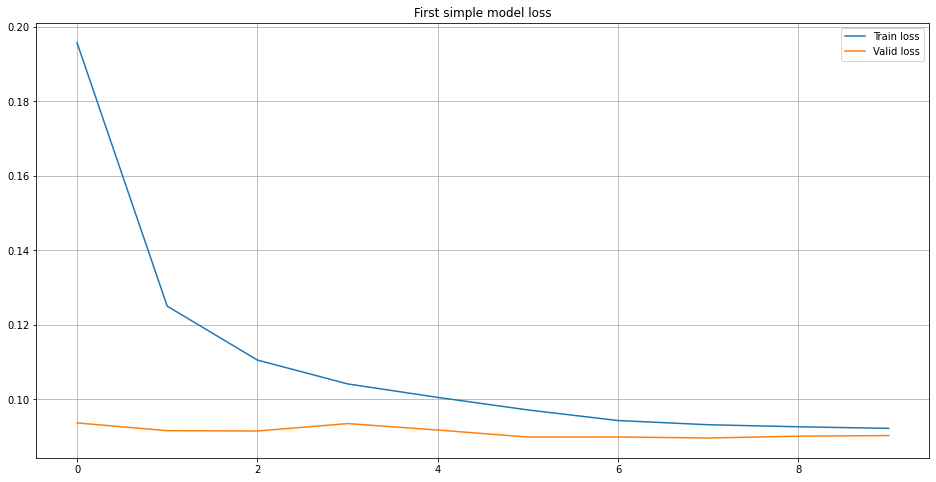

In [26]:
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=8192, shuffle=True, num_workers=2, pin_memory=True)


net = Net(df_to_dataset.shape[1] - 1).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.MSELoss() 
#loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(net, 10, 'First simple model', train_loader, valid_loader)

In [27]:
torch.save(net.state_dict(), 'net')

In [28]:
df_to_dataset.shape[1] - 1

57